# Spectral Class Prediction using Artificial Neural Networks
Group 8 <br/>
Aiden WangYang Li

## Import the Data and Libraries

In [ ]:
import numpy as np
import torch as tc
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import time
import matplotlib.pyplot as plt
import plotly.express as px
np.set_printoptions(suppress=True) # setting the printing options 
tc.set_printoptions(profile="full")

In [2]:
# Load the csv data from the same directory.
# Return the data in numpy array format
def loadData(file_name: str):
    # Import data from the Excel file by using pandas
    data = pd.read_csv(file_name, header="infer")
    # The star color data is not unified. Change all the string to lower case, remove extra spaces
    data['Star color'] = data['Star color'].str.lower().str.strip().str.replace(' ', '-')
    return data

data = loadData("data.csv")
data


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,red,M
1,3042,0.000500,0.1542,16.60,0,red,M
2,2600,0.000300,0.1020,18.70,0,red,M
3,2800,0.000200,0.1600,16.65,0,red,M
4,1939,0.000138,0.1030,20.06,0,red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,blue,O
236,30839,834042.000000,1194.0000,-10.63,5,blue,O
237,8829,537493.000000,1423.0000,-10.73,5,white,A
238,9235,404940.000000,1112.0000,-11.23,5,white,A


## Data information

In [3]:
data.info()
data.describe()
# data["Star type"].unique()
# print(data["Spectral Class"].value_counts()["M"])
# print(data["Spectral Class"].value_counts()["B"])
# print(data["Spectral Class"].value_counts()["A"])
# print(data["Spectral Class"].value_counts()["F"])
# print(data["Spectral Class"].value_counts()["O"])
# print(data["Spectral Class"].value_counts()["K"])
# print(data["Spectral Class"].value_counts()["G"])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


## Data Visualization

### Box Plots - Compare the Star Type to every other feature

In [4]:
# https://www.kaggle.com/code/creepycrap/star-type-pred-100-acc-feat-funkyml
col = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Spectral Class', 'Star color']
for column in col:
    fig = px.box(data, x = data[column], color = 'Star type')
    fig.show()

### Correlation Plot

C:\Users\aiden\AppData\Local\Temp\ipykernel_14876\1929946454.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

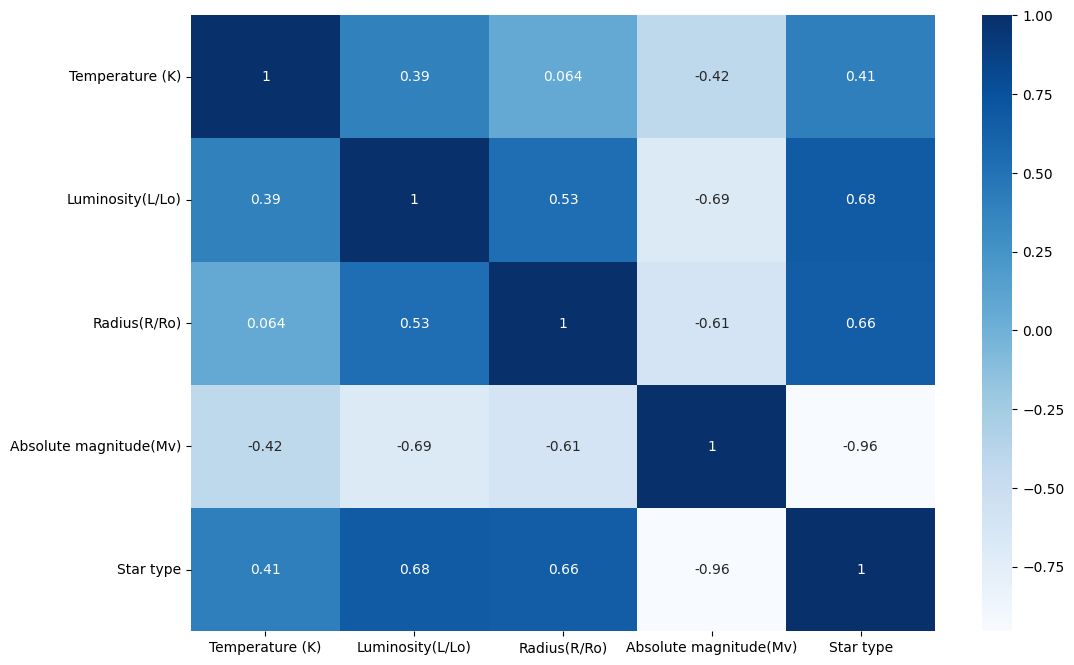

In [5]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),annot = True, cmap = 'Blues')

### Pairplot

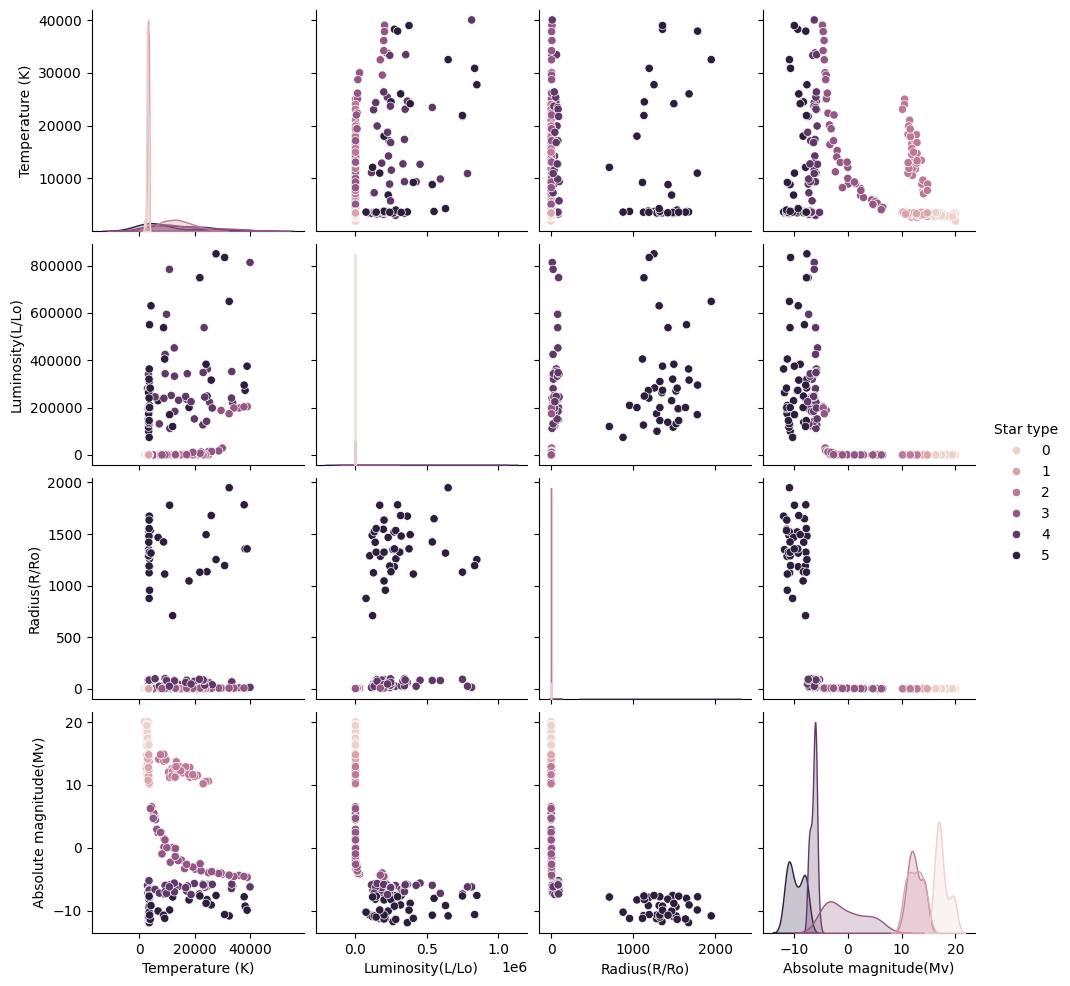

In [6]:
sns.pairplot(data, hue='Star type')
plt.show()

In [7]:
# https://www.kaggle.com/code/d4rklucif3r/spectral-classes-plotly-luciferml-93
fig = px.scatter_3d(data, x='Star type', y='Absolute magnitude(Mv)', z='Spectral Class',
                    color='Temperature (K)', template = 'plotly_dark', title = 'Distribution of Star type and Spectral Class with their Magnitudes')
fig.show()

From Above plot we can coclude that Stars having Spectral Class O tends to have highest Temperature

## Manage Data Structure for Analysis
Including Cross-validation for later use

In [8]:
from sklearn.model_selection import train_test_split

# Change all data classes from string to number
def changeClassDataType(data, data_class):
    data = np.asarray(data) # Convert the data type to numpy
    for i in range(len(data_class)):
        data[data == data_class[i]] = i
    return data

# Apply one-hot encoding to the dataset
def oneHotEncode(data: pd.arrays, data_class: list):
    one_hot_encoded_data = pd.get_dummies(data, columns = data_class, dtype=float)
    return one_hot_encoded_data

# Split the data to dataset and class labels
def splitDataLabels(data: np.ndarray, index: int):
    data = np.asarray(data, dtype=float)
    labels = np.asarray(data[:, index], dtype=int)
    dataset = np.asarray(np.delete(data, index, 1), dtype=float)
    return dataset, labels

# Calculate mean centered method to the input data matrax
# return mean centered matrix, mean value, and standard deviation value
def scaleTrainData(data: np.ndarray):
    # Change all the data type to float
    X = np.asarray(data, dtype=np.float64)
    # Calculate the mean value of each column for the matrix
    X_mean = np.mean(X, axis=0)
    # Calculate the standard deviation value of each column for the matrix
    X_std = np.std(X, axis=0)
    # when all the data is zero, the std is zero. change std to 1 to avoid divide by zero error
    X_std[X_std == 0] = 1 
    # Calculate the scaled matrix.
    X_mc = (X - X_mean)/X_std
    return X_mc, X_mean, X_std

# Calculate mean centered method to the input data matrax
# return mean centered matrix, mean value, and standard deviation value
def scaleTestData(data: np.ndarray, X_mean: np.ndarray, X_std: np.ndarray):
    # Change all the data type to float
    X = np.asarray(data, dtype=np.float64)
    # Calculate the scaled matrix.
    X_mc = (X - X_mean)/X_std
    return X_mc

# Shuffle the data by using the magical number 42, 
# then separate the data by 70% for training, 30% for testing
def trainTestSplit(data, labels, train_size, test_size):
    training_data, testing_data, training_labels, testing_labels \
        = train_test_split(data,labels, test_size=test_size, train_size=train_size, random_state=35, shuffle=True)
    return training_data, training_labels, testing_data, testing_labels

# Convert train and test data to tensor format
def formatTensorData(data, labels):
    # Convert dataset format to tensor
    tensor_data = tc.tensor(data).float()
    tensor_labels = tc.tensor(labels).long()
    return tensor_data, tensor_labels

# Cross validation, split the dataset to testing data and validation data
# i: 0,1,2,3,4 => 0~20%,20%~40%,40%~60%,60%~80%,80%~100%
# Inputs: Train data, Train labels, number of folds, partition index
# Return: The training data and testing data based on input partition index
def crossValidation(data, labels, k_folds, i):
    test_percentage = 1/k_folds
    # Set the partition indices
    _start = int(np.ceil((len(data)*test_percentage*i)))
    _end = int(np.ceil((len(data)*test_percentage*(i+1))))
    # Get the validation data for testing
    vtest_data = data[_start:_end]
    # Remove the validation data, keep the rest for training
    vtrain_data = np.delete(data, np.s_[_start:_end], axis=0)
    # Do the same thing from above for the labels
    vtest_labels = labels[_start:_end]
    vtrain_labels = np.delete(labels, np.s_[_start:_end], axis=0)
    return vtrain_data, vtrain_labels, vtest_data, vtest_labels

# Format the given partition of data for cross validation
def crossValidationPartition(data, labels, k_folds, index):
    # Cross Validation split based on number of folds
    train_data, train_labels, test_data, test_labels = crossValidation(data, labels, k_folds, index)

    # Scaled the data
    scaled_train, train_mean, train_std = scaleTrainData(train_data)
    scaled_test = scaleTestData(test_data, train_mean, train_std)

    # Convert dataset format to tensor
    train_data, train_labels = formatTensorData(scaled_train, train_labels)
    test_data, test_labels = formatTensorData(scaled_test, test_labels)

    return train_data, train_labels, test_data, test_labels

print("Spectral Class Labels:")
print(data['Spectral Class'].unique())

class_labels = ['M', 'B', 'A', 'F', 'O', 'K', 'G']
one_hot_encoded_data = oneHotEncode(data, ['Star color', 'Spectral Class'])
# one_hot_encoded_data.iloc[:, [5,7,10,11,15]]
# numerical_data = changeClassDataType(one_hot_encoded_data, class_labels)
# the class label is on the 5th column, after removing the original 'star type' by oneHotEncode 
labelidx = data.columns.get_loc('Star type')
dataset, labels = splitDataLabels(one_hot_encoded_data, labelidx) 
# split the data to training for cross validation and testing for final test
train_size = 0.8
test_size = 0.2
validation_data, validation_labels, final_test_data, final_test_labels = trainTestSplit(dataset, labels, train_size, test_size)

train_size = 0.8
test_size = 0.2
train_data, train_labels, test_data, test_labels = trainTestSplit(validation_data, validation_labels, train_size, test_size)

# Scale the data, includs mean centering and std dividing
scaled_train, train_mean, train_std = scaleTrainData(train_data)
scaled_test = scaleTestData(test_data, train_mean, train_std)
scaled_final = scaleTestData(final_test_data, train_mean, train_std)
# Convert dataset format to tensor
train_data, train_labels = formatTensorData(scaled_train, train_labels)
test_data, test_labels = formatTensorData(scaled_test, test_labels)
final_test_data, final_test_labels = formatTensorData(scaled_final, final_test_labels)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data, train_labels)
test_dataset  = TensorDataset(test_data, test_labels)

Spectral Class Labels:
['M' 'B' 'A' 'F' 'O' 'K' 'G']


## Define ANN Models

In [9]:
# Global parameter
_input = 23     # Number of input features
_output = 6     # Number of output classes
_nodes = 24     # Number of hidden units

# Create a class for the ANN model
class ANN(nn.Module):
  def __init__(self):
    super().__init__()

    ### Input layer, the input feature number is _input
    self.input = nn.Linear(_input, _nodes)
    # Define the input layer as a linear (fully connected) layer.
    # It takes input with x features and produces output with y units (neurons).
    ### Hidden layers
    self.fc1 = nn.Linear(_nodes, _nodes)
    # Define the first hidden layer as a linear layer.
    # It takes input from the previous layer with x units and produces output with y units.
    ### Output layer, the output class number is _output
    self.output = nn.Linear(_nodes, _output)
    # Define the output layer as a linear layer.
    # It takes input from the last hidden layer with y units and produces a single output (1 unit).
  
  # Forward pass
  def forward(self, x):
    x = F.tanh(self.input(x))
    # Pass the input data 'x' through the input layer and apply the ReLU activation function.
    x = F.tanh(self.fc1(x))
    # Pass the data through the first hidden layer and apply ReLU activation.
    # return F.softmax(self.output(x), dim=1)
    return self.output(x)
    # Pass the data through the output layer and return the network's output.


# Define a custom neural network class 'ANN' 
# with customizable input/output/hidden units, layers, and activation function
class ANN_Customizable(nn.Module):
    def __init__(self, nUnits, nLayers, _input, _output, actFun):
        super().__init__()

        # Create a dictionary to store the layers.
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers
        self.input = _input
        self.output = _output
        self.actfun = actFun    # activation funcion to pass through

        # Input layer.
        self.layers['input'] = nn.Linear(_input, nUnits)

        # Hidden layers.
        for i in range(nLayers):
            self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

        # Output layer.
        self.layers['output'] = nn.Linear(nUnits, _output)

    # Forward pass through the network.
    def forward(self, x):
        # this code replaces torch.relu with torch.<self.actfun>
        actfun = getattr(tc, self.actfun)
        x = actfun(self.layers['input'](x))  # Input layer (with ReLU activation).

        # Hidden layers with ReLU activation.
        for i in range(self.nLayers):
            x = actfun(self.layers[f'hidden{i}'](x))

        # x = F.softmax(self.layers['output'](x), dim=1)  # Output layer.
        x = self.layers['output'](x)  # Output layer.
        return x

## Define Traning & Testing Model

In [10]:
# Define a function to train the model.
def trainModel(ann, train_data, train_labels, test_data, test_labels, epochs, learning_rate, optimizerType):
    # Specify the Loss function and optimizer
    loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification.
    optifun = getattr(tc.optim, optimizerType)
    optimizer = optifun(ann.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer.
    # optimizer = tc.optim.SGD(ann.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer.

    # Initialize lists for losses ('custom_losses') and ongoing accuracy ('custom_ongoing_accuracy').
    losses = []
    trainAcc = []
    testAcc = []
    
    # Training loop.
    for epochi in range(epochs):
        # Switch on training mode for the neural network
        ann.train()
        # Forward pass.
        yHat = ann(train_data)

        # Compute loss.
        loss = loss_func(yHat, train_labels)
        losses.append(loss.item())

        # Backpropagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy.
        matches = tc.argmax(yHat, axis=1) == train_labels       # Booleans (false/true).
        matches_numeric = matches.float()                       # Convert to numbers (0/1).
        accuracy_pct = 100 * tc.mean(matches_numeric).item()    # Average and x100.
        trainAcc.append(accuracy_pct)             # Add to list of accuracies.

        ann.eval()
        with tc.no_grad():  # Deactivate autograd (no gradient tracking)
            test_pred = ann(test_data)  # Forward pass to get test predictions
        testAcc.append(100 * tc.mean((tc.argmax(test_pred, axis=1) == test_labels).float()).item())
    
    # # Calculate the total number of trainable parameters in the model.
    # nParams = sum(p.numel() for p in ann.parameters() if p.requires_grad)
    
    # Function output: Returns ongoing training accuracies, ongoing test accuracies, and losses    
    return trainAcc, testAcc, losses


# Define a function to train the model in batch
def trainBatchModel(ann, train_loader, test_loader, num_epochs, learning_rate, optimizerType):
    # Specify the Loss function and optimizer
    loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification.
    optifun = getattr(tc.optim, optimizerType)
    optimizer = optifun(ann.parameters(), lr=learning_rate)  # Stochastic Gradient Descent optimizer.
    # optimizer = tc.optim.SGD(ann.parameters(), lr=learning_rate)  # Stochastic Gradient Descent (SGD) optimizer

    # Initialize lists to store training statistics
    losses = []     # To store losses at each epoch
    trainAcc = []   # To store training accuracies
    testAcc = []    # To store test accuracies

    # Loop over epochs
    for epochi in range(num_epochs):
        # Switch on training mode for the neural network
        ann.train()
        # Initialize lists to store batch-wise training statistics
        batchAcc = []    # To store batch accuracies
        batchLoss = []   # To store batch losses

        # Loop over training data batches
        for train_data, train_labels in train_loader:
            # Forward pass and compute loss
            yHat = ann(train_data)  # Forward pass to get predictions
            loss = loss_func(yHat, train_labels)  # Compute the loss between predictions and actual labels

            # Backpropagation
            optimizer.zero_grad()  # Zero out gradients
            loss.backward()        # Backpropagate the loss
            optimizer.step()       # Update model parameters using the optimizer

            # compute training accuracy just for this batch
            batchAcc.append(100 * tc.mean((tc.argmax(yHat, axis=1) == train_labels).float()).item())
            # Calculate the training accuracy for this mini-batch.
            # - `torch.argmax(yHat, axis=1)` finds the index of the maximum predicted value for each sample.
            # - `(torch.argmax(yHat, axis=1) == y)` checks if the predicted labels match the true labels.
            # - `torch.mean(...).item()` calculates the accuracy as a percentage.
            # End of batch loop...

            # Store the loss from this batch
            batchLoss.append(loss.item())

        # Calculate and store the average training accuracy across all mini-batches for this epoch.
        trainAcc.append(np.mean(batchAcc))
        # Calculate and store the average loss across all mini-batches for this epoch.
        losses.append(np.mean(batchLoss))

        # Test accuracy
        ann.eval()  # Switch to evaluation mode (no gradient computation)
        test_data, test_labels = next(iter(test_loader))  # Extract X, y from the test dataloader
        with tc.no_grad():  # Deactivate autograd (no gradient tracking)
            test_pred = ann(test_data)  # Forward pass to get test predictions
        # testAcc.append(100 * tc.mean(((yHat > 0) == label).float()).item())
        testAcc.append(100 * tc.mean((tc.argmax(test_pred, axis=1) == test_labels).float()).item())
        # - `test_pred == y` checks if the predicted labels match the true labels.
        # - `torch.mean(...).item()` calculates the accuracy as a percentage.

    # Function output: Returns ongoing training accuracies, ongoing test accuracies, and losses
    return trainAcc, testAcc, losses

# Define a function to test the model.
def testModel(ann, test_data, test_labels):
    # Switch to evaluation mode (no gradient computation)
    ann.eval()
    pred_labels = ann(test_data)                                # Forward pass.
    matches = tc.argmax(pred_labels, axis=1) == test_labels     # Booleans (false/true).
    accuracy = 100 * tc.mean(matches.float())                   # Average and x100.
    return accuracy

## Fine-tune the HyperParameters

### Find the Optimal Optimizer

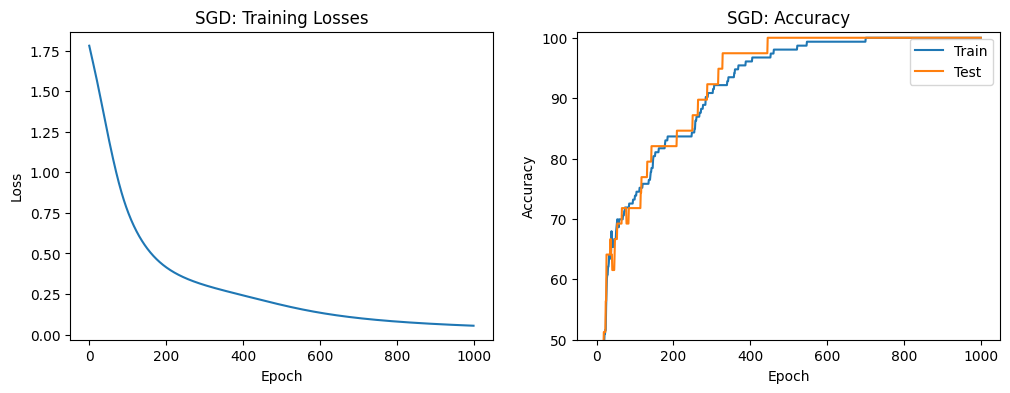

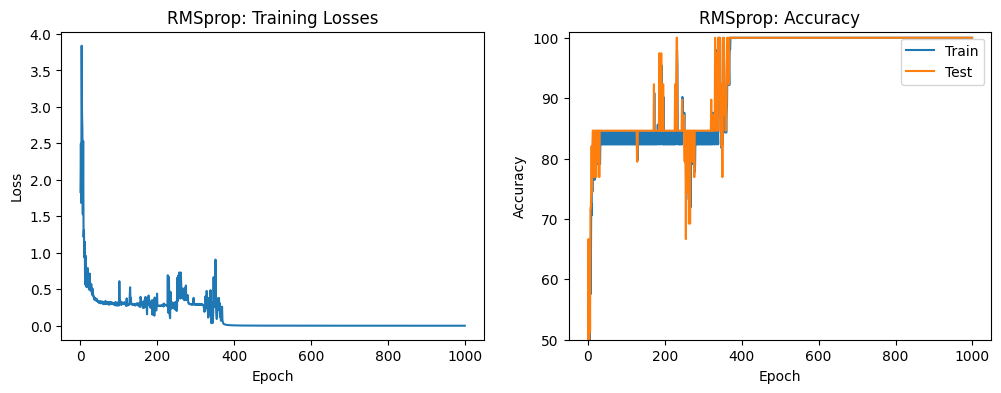

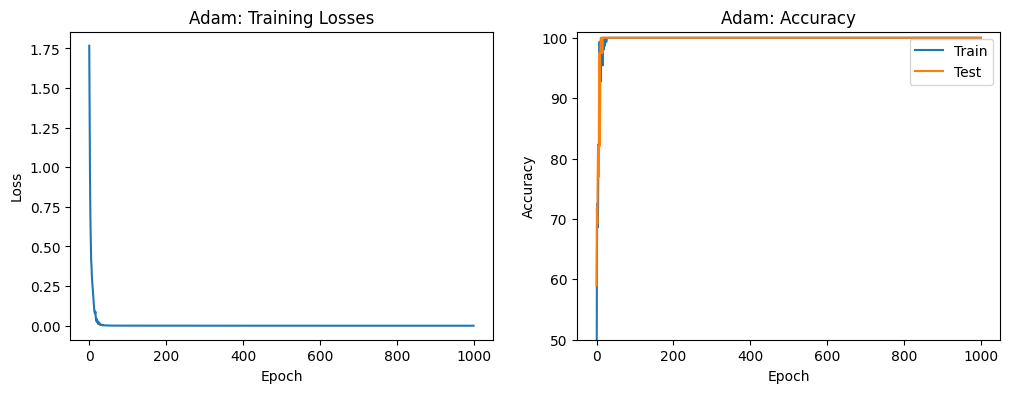

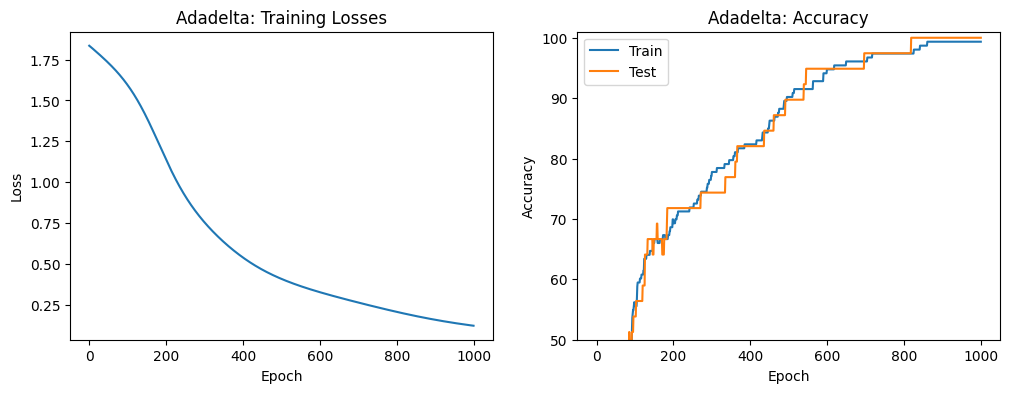

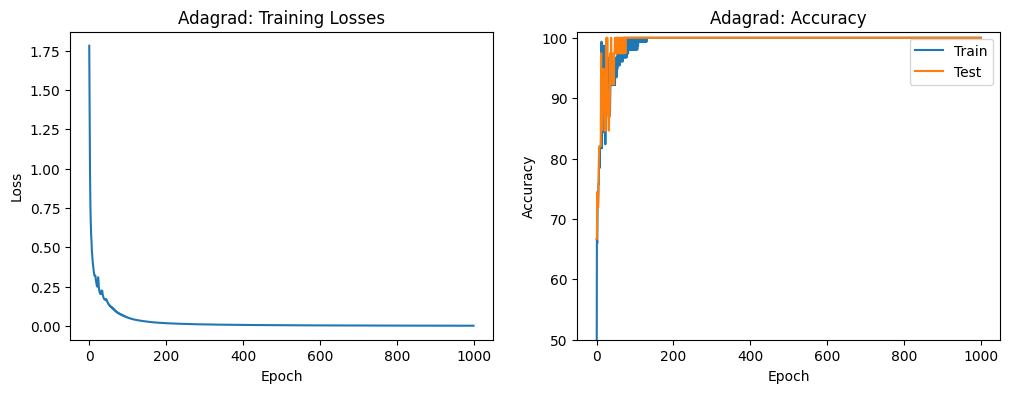

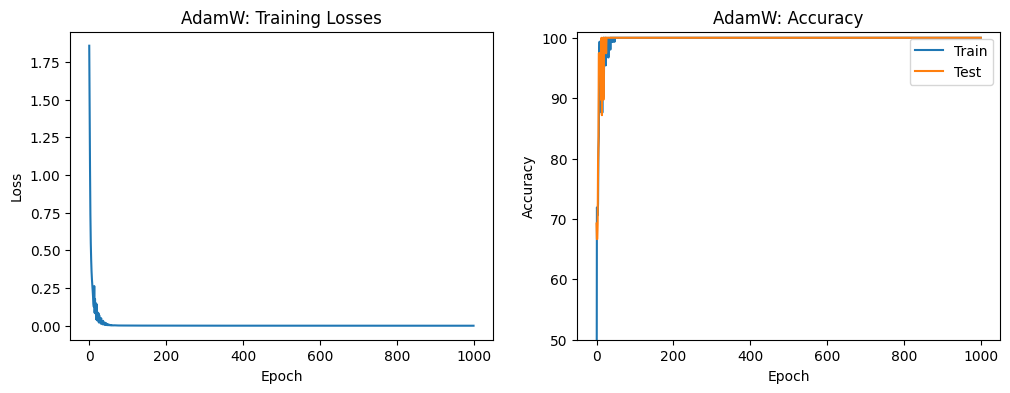

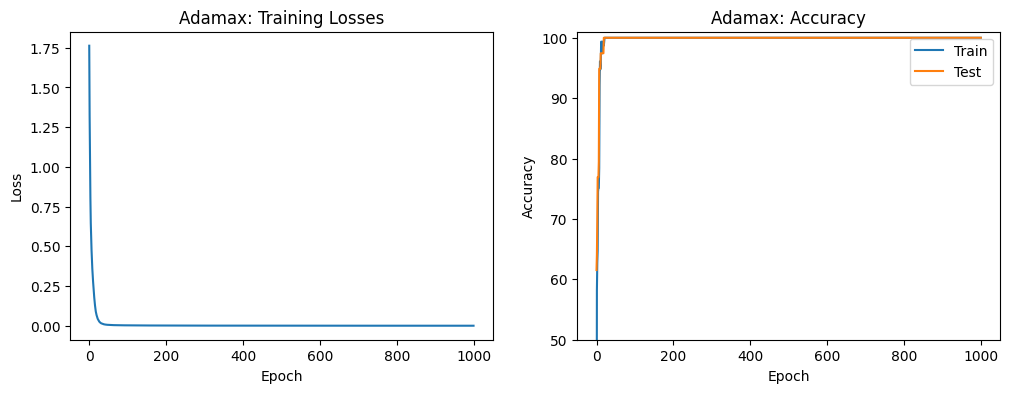

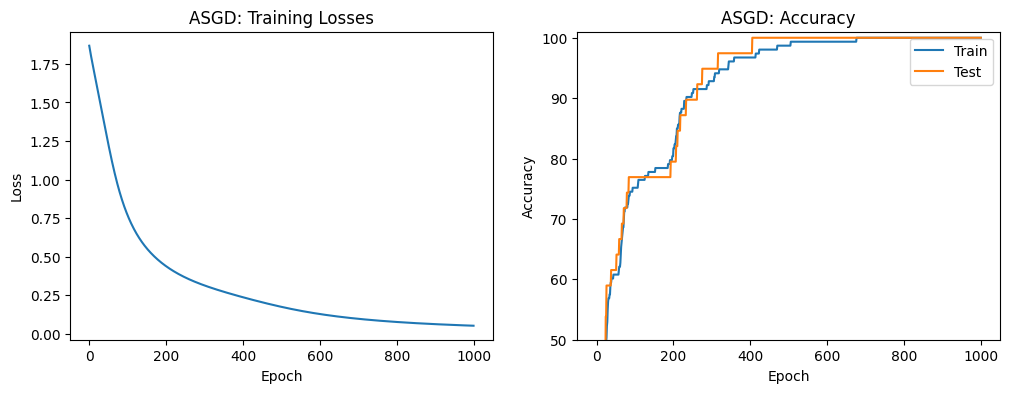

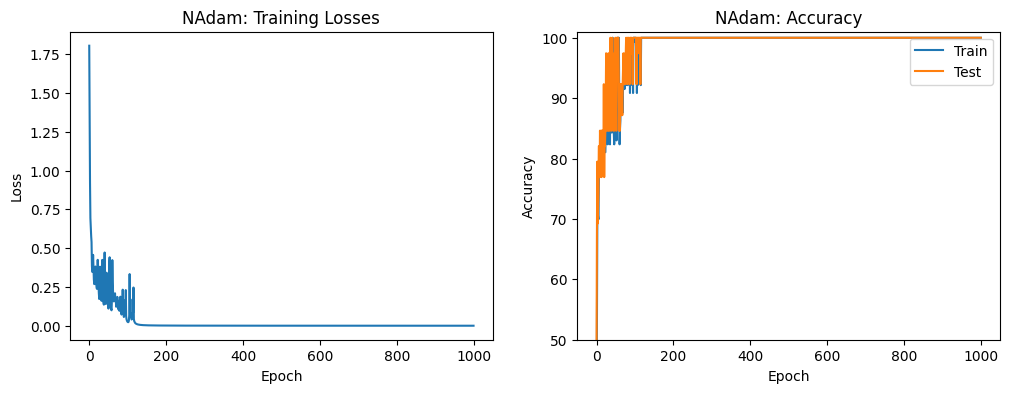

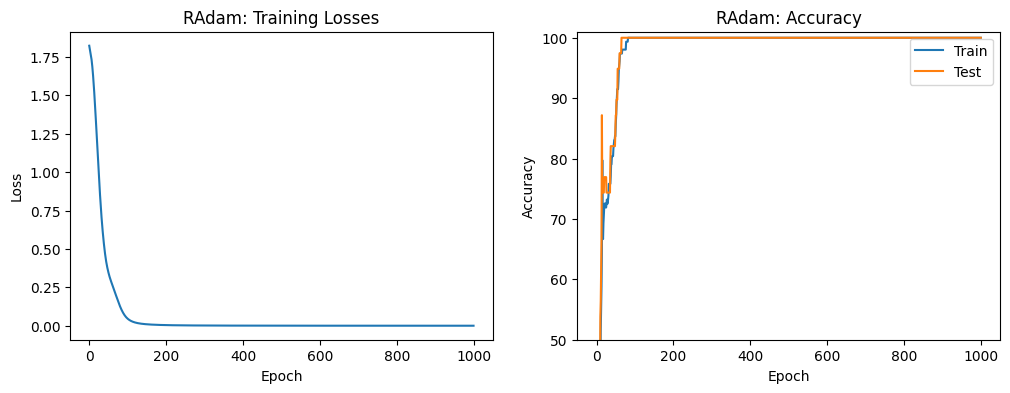

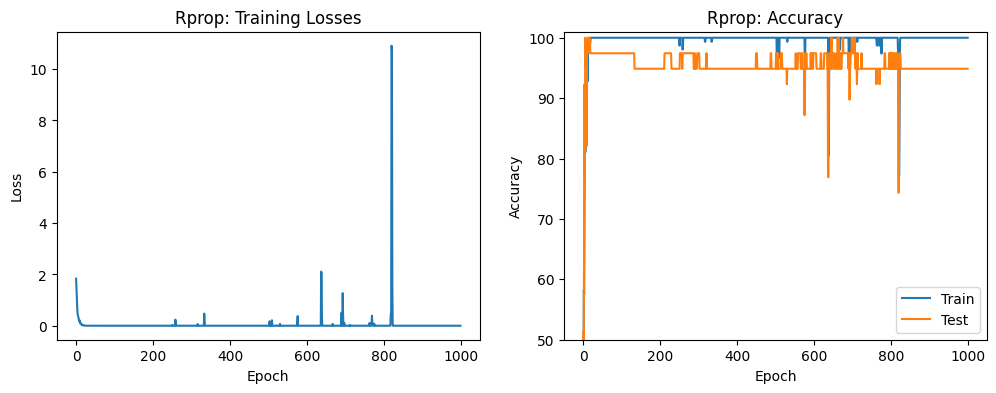

['SGD: train 100.0%, test 100.0%',
 'RMSprop: train 100.0%, test 100.0%',
 'Adam: train 100.0%, test 100.0%',
 'Adadelta: train 99.3%, test 100.0%',
 'Adagrad: train 100.0%, test 100.0%',
 'AdamW: train 100.0%, test 100.0%',
 'Adamax: train 100.0%, test 100.0%',
 'ASGD: train 100.0%, test 100.0%',
 'NAdam: train 100.0%, test 100.0%',
 'RAdam: train 100.0%, test 100.0%',
 'Rprop: train 100.0%, test 94.9%']

In [11]:
# Initialize a list to store performance results
performance = []
numepochs = 1000
learning_rate = 0.05   # Number of learning rate

optList = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'AdamW', 'Adamax', 'ASGD', 'NAdam', 'RAdam', 'Rprop'] # 
# Iterate through optimizer types
for optimizer in optList:
    ann = ANN()
    # The function returns training accuracy, test accuracy, losses, and the trained neural network model itself.
    trainAccList, testAccList, losses \
        = trainModel(ann, train_data, train_labels, test_data, test_labels, numepochs, learning_rate, optimizer)
    # Calculate and store the average accuracy
    train_avg = np.mean(trainAccList[-10:])
    test_avg = np.mean(testAccList[-10:])

    performance.append(f'{optimizer}: train {train_avg:.1f}%, test {test_avg:.1f}%')
    # Visualize the training results for the specified optimizer
    # Create subplots for losses and accuracy.
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot training losses.
    ax[0].plot(losses)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_title(f'{optimizer}: Training Losses')

    # Plot ongoing accuracy during training.
    ax[1].plot(trainAccList, label='Train')
    ax[1].plot(testAccList,label='Test')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title(f'{optimizer}: Accuracy')
    ax[1].set_ylim([50,101])
    ax[1].legend()
    plt.show()

performance

Optimizer options: SGD, Adam, Adadelta, RAdam

### Find the Optimal Loss Function
We decide to use the Cross Entropy Loss function, as it suits our multi-class classification problem.

### Find the Optimal Number of Learning Rate & Optimizer

Using Optimizer SGD
Average Training Accuracy: 98.86
Average Testing Accuracy:  98.92
Learning rate with highest accuracy: 0.062


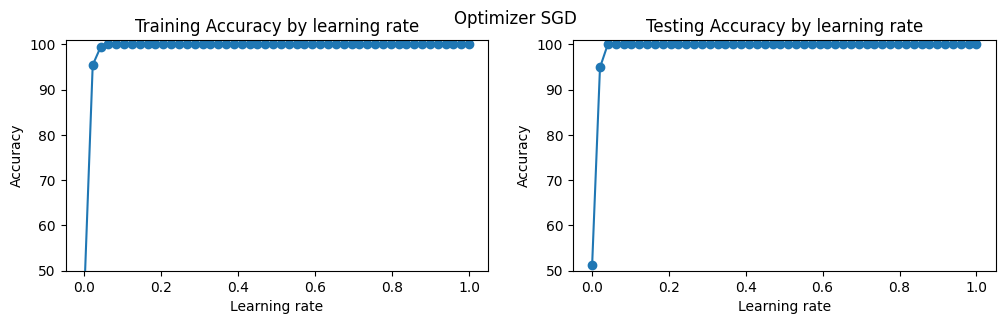

Using Optimizer RMSprop
Average Training Accuracy: 68.77
Average Testing Accuracy:  68.51
Learning rate with highest accuracy: 0.001


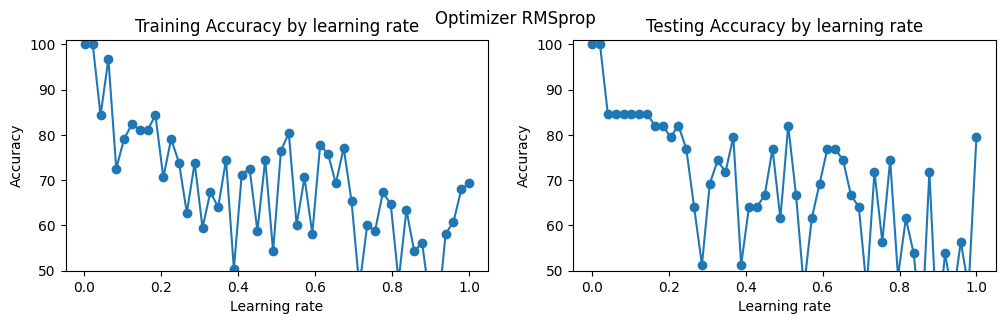

Using Optimizer Adam
Average Training Accuracy: 83.96
Average Testing Accuracy:  84.31
Learning rate with highest accuracy: 0.001


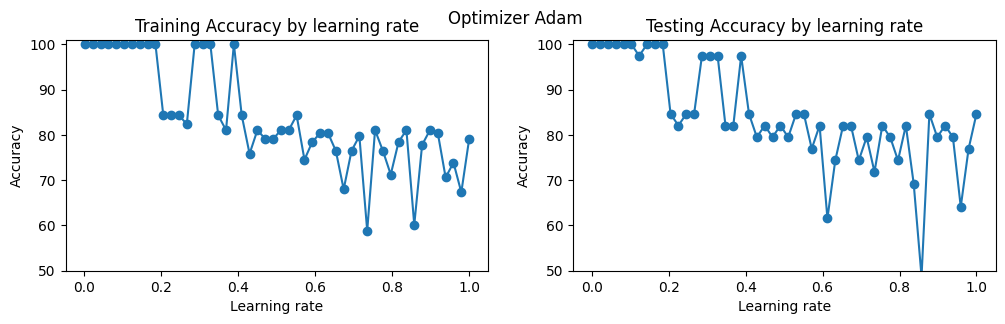

Using Optimizer Adadelta
Average Training Accuracy: 97.96
Average Testing Accuracy:  98.05
Learning rate with highest accuracy: 0.083


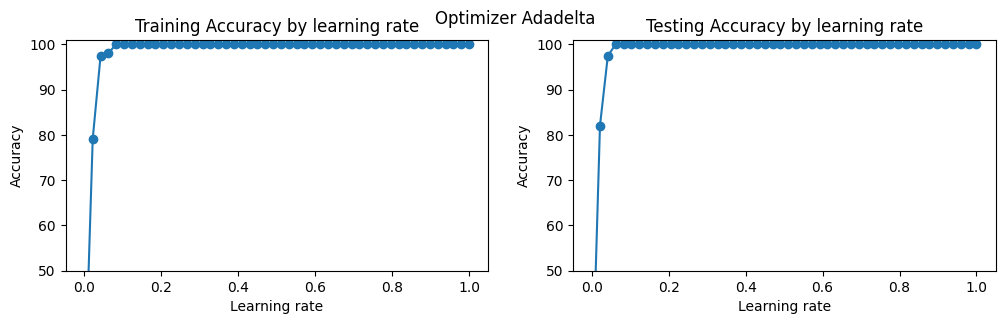

In [12]:
# Set the hyperparameters
numepochs = 800             # Number of epochs
# optimizer = 'SGD'      # optimizer function name
lr_start = 0.001         # The staring value of the learning rate
lr_end = 1              # The ending value of the learning rate
lr_num = 50             # The number of learning rates show on the plots
# Test on learning  rate
learningrates = np.linspace(lr_start,lr_end,lr_num)
optList = ['SGD', 'RMSprop', 'Adam', 'Adadelta']

def findOptimalLearningRateForOptimizer(numepochs, learningrates, optimizer):
    print("Using Optimizer " + optimizer)
    # initialize
    trainaccByLR = []
    testaccByLR = []
    highestTrainAcc = 0
    best_lr = 0

    # the loop
    for i ,lr in enumerate(learningrates):
        
        # create and run the model
        ann = ANN()
        trainAccList, testAccList, losses \
        = trainModel(ann, train_data, train_labels, test_data, test_labels, numepochs, lr, optimizer)
        # get the last/optimal accuracy from the list
        finalTrainAcc = trainAccList[-1]
        finalTestAcc = testAccList[-1]
        # store the final accuracy of each
        trainaccByLR.append(finalTrainAcc)
        testaccByLR.append(finalTestAcc)

        if finalTrainAcc > highestTrainAcc: 
            highestTrainAcc = finalTrainAcc 
            best_lr = lr

    # plot the results
    fig,ax = plt.subplots(1,2,figsize=(12,3))
    fig.suptitle("Optimizer " + optimizer)
    print("Average Training Accuracy: %.2f" % np.mean(trainaccByLR, axis=0))
    print("Average Testing Accuracy:  %.2f" % np.mean(testaccByLR, axis=0))
    print("Learning rate with highest accuracy: %.3f" % best_lr)
    ax[0].plot(learningrates,trainaccByLR,'o-')
    ax[0].set_xlabel('Learning rate')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training Accuracy by learning rate')
    ax[0].set_ylim([50,101])
    ax[1].plot(learningrates,testaccByLR,'o-')
    ax[1].set_xlabel('Learning rate')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Testing Accuracy by learning rate')
    ax[1].set_ylim([50,101])
    plt.show()
    return trainaccByLR

for i, optimizer in enumerate(optList):
    data = findOptimalLearningRateForOptimizer(numepochs, learningrates, optimizer)
# SGDdata = []
# Adamdata = []
# optList = ['SGD', 'Adam']
# # Loop through each optimizer
# for i, optimizer in enumerate(optList):
#     data = findOptimalLearningRateForOptimizer(numepochs, learningrates, optimizer)
#     if optimizer == 'SGD':
#         SGDdata = data
#     if optimizer == 'Adam':
#         Adamdata = data

# fig,ax = plt.subplots(1,2,figsize=(12,4))
# fig.suptitle("Optimizer SGD vs. Adam")
# ax[0].plot(learningrates,SGDdata,'o-')
# ax[0].set_xlabel('Learning rate')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_title('SGD Accuracy by Learning Rate')
# ax[0].set_ylim([50,101])
# ax[1].plot(learningrates,Adamdata,'o-')
# ax[1].set_xlabel('Learning rate')
# ax[1].set_ylabel('Accuracy')
# ax[1].set_title('Adam Accuracy by Learning Rate')
# ax[1].set_ylim([50,101])
# plt.show()



The optimal learning rates:  
SGD: 1  
RMSprop: 0.1  
Adam: 0.1  
Adadelta: 1

We decide to choose SGD and Adam for further testing

### Find the Optimal Number of Epoch

Using Optimizer SGD
Final accuracy of training ANN model: 100%
Final accuracy of testing ANN model: 100%
Computation Time 2.5938 miliseconds


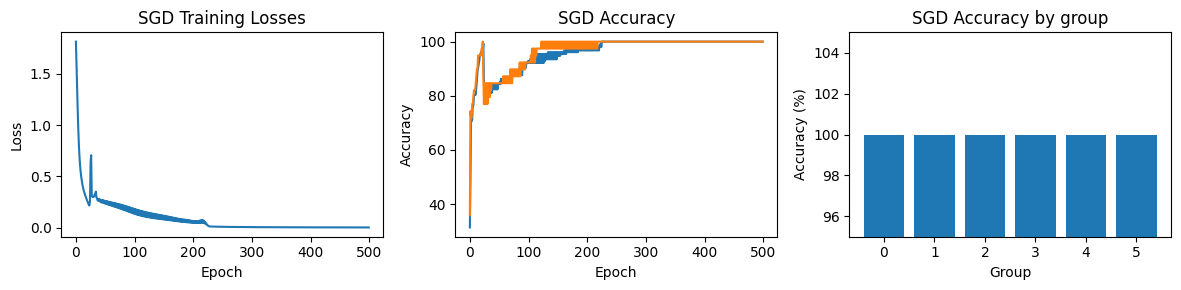

Using Optimizer RMSprop
Final accuracy of training ANN model: 100%
Final accuracy of testing ANN model: 100%
Computation Time 3.1406 miliseconds


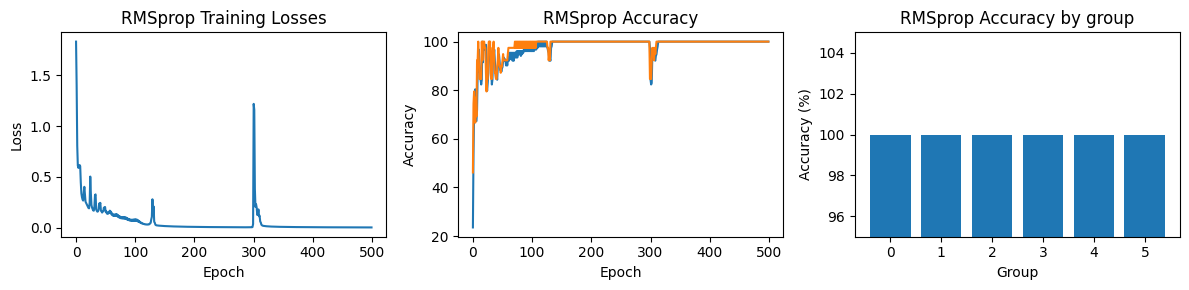

Using Optimizer Adam
Final accuracy of training ANN model: 100%
Final accuracy of testing ANN model: 100%
Computation Time 3.4688 miliseconds


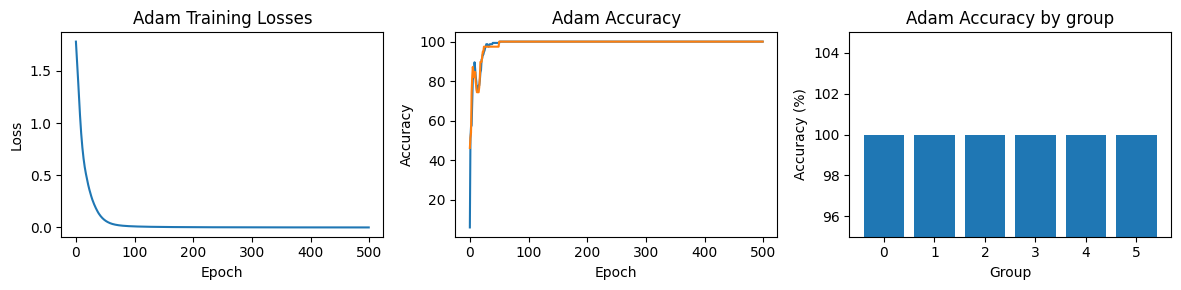

Using Optimizer Adadelta
Final accuracy of training ANN model: 100%
Final accuracy of testing ANN model: 100%
Computation Time 3.4844 miliseconds


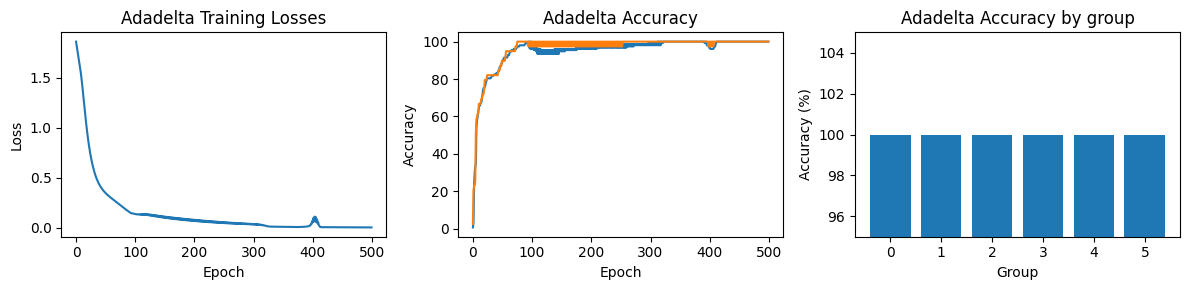

In [13]:
# Set the hyperparameters
numepochs = 500
optList = ['SGD', 'RMSprop', 'Adam', 'Adadelta']
lrList = [1, 0.01, 0.01, 1]
nClasses = 6

def findOptimalEpochForOptimizer(numepochs, learning_rate, optimizer):
    print("Using Optimizer " + optimizer)
    # Start the timer to measure computation time
    starttime = time.process_time()
    
    # Create a model
    ann = ANN()

    # train the data
    trainAccList, testAccList, losses \
        = trainModel(ann, train_data, train_labels, test_data, test_labels, numepochs, learning_rate, optimizer)
    # Get the final training accuracy.
    finalTrain = trainAccList[-1]
    finalTest = testAccList[-1]

    # compute accuracy over entire dataset (train+test)
    yHat = ann(train_data)
    predictions = tc.argmax(yHat,axis=1)
    accuracy = (predictions == train_labels).float()
    totalAcc = tc.mean(100*accuracy).item()
    # and accuracy by group
    accuracyByGroup = np.zeros(nClasses)
    for i in range(nClasses):
        accuracyByGroup[i] = 100*tc.mean(accuracy[train_labels==i])

    # Record the computation time
    processtime = time.process_time() - starttime
    # Report the final accuracy of the ANN model.
    print('Final accuracy of training ANN model: %g%%' % finalTrain)
    print('Final accuracy of testing ANN model: %g%%' % finalTest)
    print("Computation Time %.4f miliseconds" % processtime)
    # Create subplots for losses and accuracy.
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    # fig.suptitle("Optimizer " + optimizer)
    # Plot training losses.
    ax[0].plot(losses)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_title(optimizer + ' Training Losses')

    # Plot ongoing accuracy during training.
    ax[1].plot(trainAccList, label='Train')
    ax[1].plot(testAccList,label='Test')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_title(optimizer + ' Accuracy')

    # plot overall accuracy by group
    ax[2].bar(range(nClasses),accuracyByGroup)
    ax[2].set_ylim([np.min(accuracyByGroup)-5,np.max(accuracyByGroup)+5])
    ax[2].set_xticks(range(nClasses))
    ax[2].set_xlabel('Group')
    ax[2].set_ylabel('Accuracy (%)')
    ax[2].set_title('%s Accuracy by group' % optimizer)
    plt.tight_layout()
    plt.show()
    return trainAccList, testAccList


# Loop through each optimizer
for i, optimizer in enumerate(optList):
    findOptimalEpochForOptimizer(numepochs, lrList[i], optimizer)

# SGDtrain = []
# SGDtest = []
# Adamtrain = []
# Adamtest = []
# optList = ['SGD', 'Adam']
# lrList = [0.1, 0.01]
# # Loop through each optimizer
# for i, optimizer in enumerate(optList):
#     trainAccList, testAccList = findOptimalEpochForOptimizer(numepochs, lrList[i], optimizer)
#     if optimizer == 'SGD':
#         SGDtrain = trainAccList
#         SGDtest = testAccList
#     if optimizer == 'Adam':
#         Adamtrain = trainAccList
#         Adamtest = testAccList


# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# fig.suptitle("Optimizer SGD vs. Adam")
# # Plot training losses.
# ax[0].plot(SGDtrain, label='Train')
# ax[0].plot(SGDtest,label='Test')
# ax[0].set_ylabel('Accuracy')
# ax[0].set_xlabel('Epoch')
# ax[0].set_title('SGD Accuracy by Epoch')

# # Plot ongoing accuracy during training.
# ax[1].plot(Adamtrain, label='Train')
# ax[1].plot(Adamtest,label='Test')
# ax[1].set_ylabel('Accuracy')
# ax[1].set_xlabel('Epoch')
# ax[1].set_title('Adam Accuracy by Epoch')
# plt.show()

From the plot above, we can see that the best epoch number is around 500.   
The acceptable optimizers are SGD, Adam, and Adadelta, where Adam is the best choice with the fastiest converge rate.
The best epoch number for Adam is around 300.


### Find the Optimal Number of Hidden Layers and Units with Different Activation Functions

Using Activation Function relu


c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\init.py:405: UserWarning:

Initializing zero-element tensors is a no-op



Best # of Layer is: 1 with the highest average accuracy of 95.61%.
Please choose the number of units based on the plot.
Using Activation Function tanh
Best # of Layer is: 0 with the highest average accuracy of 95.05%.
Please choose the number of units based on the plot.
Using Activation Function sigmoid
Best # of Layer is: 1 with the highest average accuracy of 93.65%.
Please choose the number of units based on the plot.


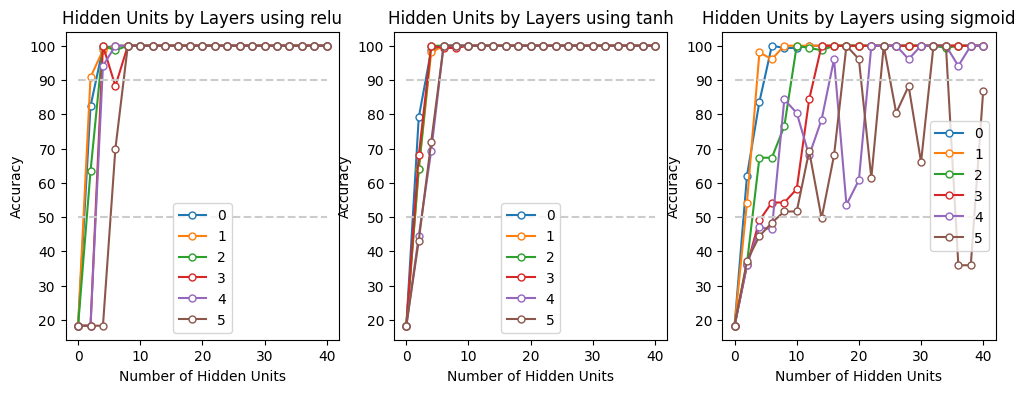

In [14]:
# Set the hyperparameters
numepochs = 300             # Number of training epochs
learning_rate = 0.01        # Number of learning rate          
optimizer = 'Adam'          # optimizer function name
activation_funs = ['relu', 'tanh', 'sigmoid']   # activation function for hidden layer    

def findOptimalHiddenLayersUnits(actFunHidden, optimizer, learning_rate, num_epochs, i):
    print("Using Activation Function " + actFunHidden)
    # Define the model parameters: number of layers and number of units per layer.
    numlayers = range(0, 6)          # Number of hidden layers.
    numunits = np.arange(0, 41, 2)  # Units per hidden layer.

    # Initialize matrices to store accuracies and total parameters.
    accuracies = np.zeros((len(numunits), len(numlayers)))

    # Start the experiment by varying the number of units and layers.
    for unitidx in range(len(numunits)):
        for layeridx in range(len(numlayers)):
            # Create a fresh model instance.
            ann = ANN_Customizable(numunits[unitidx], numlayers[layeridx], _input, _output, actFunHidden)

            # Train the model and store the results.
            train_accuracy, test_accuracy, losses \
                = trainModel(ann, train_data, train_labels, test_data, test_labels, num_epochs, learning_rate, optimizer)
            accuracies[unitidx, layeridx] = train_accuracy[-1]

            # # Store the total number of parameters in the model.
            # totalparams[unitidx, layeridx] = nParams

    accuracyList = np.mean(accuracies, axis=0)  
    bestNumLayer = np.argmax(accuracyList)     
    bestAcc = accuracyList[bestNumLayer]
    print("Best # of Layer is: %d with the highest average accuracy of %.2f%%." % (bestNumLayer, bestAcc))
    print("Please choose the number of units based on the plot.")
    # Show accuracy as a function of the number of hidden units for different layers.
    
    ax[i].plot(numunits, accuracies, 'o-', markerfacecolor='w', markersize=5)
    ax[i].plot(numunits[[0, -1]], [50, 50], '--', color=[0.8, 0.8, 0.8])
    ax[i].plot(numunits[[0, -1]], [90, 90], '--', color=[0.8, 0.8, 0.8])
    ax[i].legend(numlayers)
    ax[i].set_ylabel('Accuracy')
    ax[i].set_xlabel('Number of Hidden Units')
    ax[i].set_title('Hidden Units by Layers using %s' % actFunHidden)
    
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, actFun in enumerate(activation_funs):
    findOptimalHiddenLayersUnits(actFun, optimizer, learning_rate, numepochs, i)
plt.show()


From the above plot, we can see that using relu and tanh functions are the great choices, the best layer number is 0, the best unit range is between 20 ~ 40. We will chooce 30 as the optimmal unit number.
To find the best activation function for hidden layer, we will check the traning and testing accuracy in details in the next section.  
Overall, Layer = 0, Unit = 24, Activation function for hidden layers: relu and tanh

### Find the Optimal Activation Function

Activation   Train Accuracy   Test Accuracy   
relu         96.70%           96.77%          
tanh         97.36%           97.56%          
sigmoid      91.29%           90.93%          


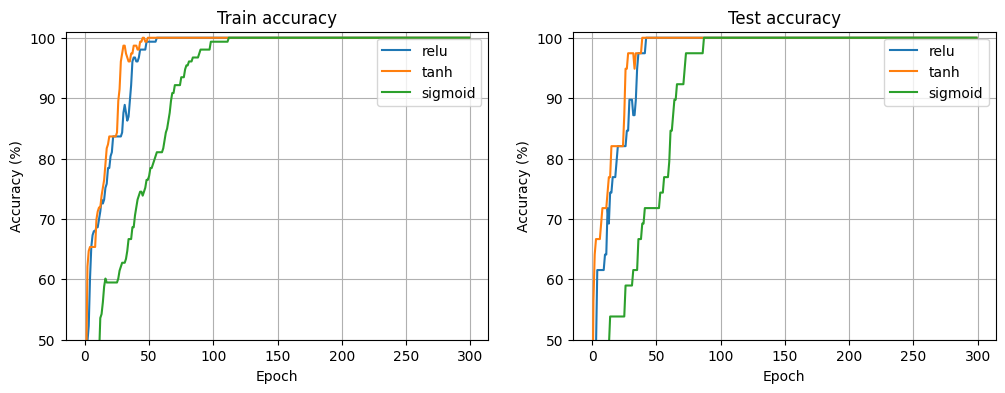

In [15]:
# Global parameter
numepochs = 300         # Number of training epochs
learning_rate = 0.01    # Number of learning rate
nLayers = 1             # Number of hidden layers
nUnits = 24             # Number of hidden units
optimizer = 'Adam'      # optimizer function name
# list activation functions to test
activation_funs = [ 'relu', 'tanh', 'sigmoid'] # 'hardshrink' bad option, remove it to avoid plot overlap

trainByAct = np.zeros((numepochs,len(activation_funs)))
testByAct  = np.zeros((numepochs,len(activation_funs)))

for ai,actfun in enumerate(activation_funs):
    # create a model and train it
    ann = ANN_Customizable(nUnits, nLayers, _input, _output, actfun)
    trainByAct[:,ai], testByAct[:,ai], losses \
        = trainModel(ann, train_data, train_labels, test_data, test_labels, numepochs, learning_rate, optimizer)

# Print the overall accuracy for each batch
train_accuracy = np.mean(trainByAct, axis=0)
test_accuracy = np.mean(testByAct, axis=0)

print("{:<12} {:<16} {:<16}".format("Activation", "Train Accuracy", "Test Accuracy"))
for i, batch in enumerate(activation_funs):
    print("{:<12} {:<16} {:<16}".format(activation_funs[i], "%.2f%%" % (train_accuracy[i]), "%.2f%%" % (test_accuracy[i])))

# plot some results
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(trainByAct)
ax[0].set_title('Train accuracy')
ax[1].plot(testByAct)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
    ax[i].legend(activation_funs)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

From the above plot, we can see the best activation function for hidden layer is tanh, with the faster convergece rate.  
We choose *Softmax* as the output layer's activation function, because this function helps with classifying data into different categories.

### Find the Optimal Mini-Batch Number 

c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning:

Mean of empty slice.

c:\Users\aiden\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



[146.        38.28125   10.34375    5.421875   0.765625   2.      ]
Batch #  Train Accuracy   Test Accuracy   
2        98.90%           99.21%          
8        99.01%           99.34%          
32       98.82%           99.20%          
128      97.01%           97.44%          
512      nan%             12.82%          
None     97.40%           97.83%          


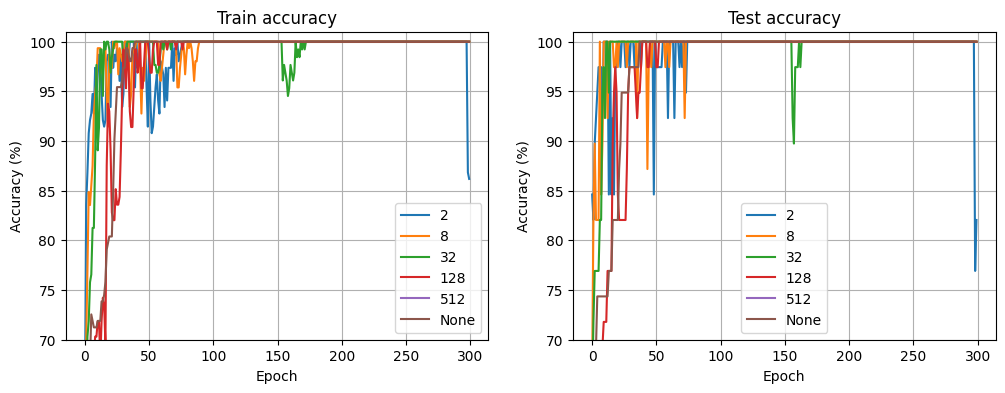

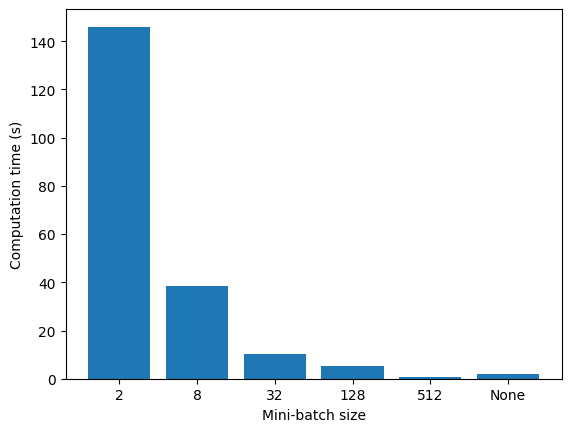

In [16]:
# This cell performs experiments to analyze the effect of different batch sizes on model training.

# Global parameter
numepochs = 300         # Number of training epochs
learning_rate = 0.01    # Number of learning rate
nLayers = 1             # Number of hidden layers
nUnits = 24             # Number of hidden units
actFunHidden = 'tanh'   # activation function for hidden layer             
optimizer = 'Adam'      # optimizer function name

# Range of batch sizes
batchsizes = 2 ** np.arange(1, 10, 2)
# Create an array of batch sizes, starting from 2 and doubling with each step, up to 512.

# Initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest = np.zeros((numepochs, len(batchsizes)))
comptime = np.zeros(len(batchsizes))
# Create empty matrices to store training and testing accuracies, as well as computation times.

# Test data doesn't vary by training batch size
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])
# Create a DataLoader for the test data. It has a batch size equal to the total number of samples in the test dataset.

# Loop over different batch sizes
for bi in range(len(batchsizes)):

    # Start the timer to measure computation time
    starttime = time.process_time()

    # Create DataLoader object for training data with the current batch size
    train_loader = DataLoader(train_dataset, 
                              batch_size=int(batchsizes[bi]), shuffle=True, drop_last=False)
    # Create a DataLoader for training data with the current batch size.
    # - 'int(batchsizes[bi])': Converts the current batch size to an integer.
    # - 'shuffle=True': Shuffles the training data.
    # - 'drop_last=True': Drops the last batch if it's smaller than the specified batch size.

    # Create and train a model
    ann = ANN_Customizable(nUnits, nLayers, _input, _output, actFunHidden)  # Create an instance of the neural network model
    # Train the model and obtain training statistics
    trainAccList, testAccList, losses = trainBatchModel(ann, train_loader, test_loader, numepochs, learning_rate, optimizer) 
    # Store training and testing accuracy results
    accuracyResultsTrain[:, bi] = trainAccList
    accuracyResultsTest[:, bi] = testAccList

    # Record the computation time
    comptime[bi] = time.process_time() - starttime

# Print the overall accuracy for each batch
train_accuracy = np.mean(accuracyResultsTrain, axis=0)
test_accuracy = np.mean(accuracyResultsTest, axis=0)

# Start the timer to measure computation time
starttime = time.process_time()
# Get the accuracy with no batch applied.
ann = ANN_Customizable(nUnits, nLayers, _input, _output, actFunHidden)
noBatchTrainAcc, noBatchTestAcc, noBatchlosses \
        = trainModel(ann, train_data, train_labels, test_data, test_labels, numepochs, learning_rate, optimizer)
# Record the computation time
comptime = np.append(comptime, (time.process_time() - starttime))
print(comptime)
accuracyResultsTrain = np.concatenate((accuracyResultsTrain, np.transpose(np.array(noBatchTrainAcc)[np.newaxis])), axis=1)
accuracyResultsTest = np.concatenate((accuracyResultsTest, np.transpose(np.array(noBatchTestAcc)[np.newaxis])), axis=1)

print("{:<8} {:<16} {:<16}".format("Batch #", "Train Accuracy", "Test Accuracy"))
for i, batch in enumerate(batchsizes):
    print("{:<8} {:<16} {:<16}".format(batchsizes[i], "%.2f%%" % (train_accuracy[i]), "%.2f%%" % (test_accuracy[i])))
print("{:<8} {:<16} {:<16}".format("None", "%.2f%%" % (np.mean(noBatchTrainAcc)), "%.2f%%" % (np.mean(noBatchTestAcc))))

# plot some results
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')
batchsizes = np.append(batchsizes, 'None')
# common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([70,101])
    ax[i].grid()
plt.show()

# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()

From the above plots, we can see that the best mini-batch size option is 32. It has lower computation time and highest accuracy on a stable prediction trend.
It is not necessary to use mini-batch in our case. we have a small set of data with only around 300 data. The mini-batch increases the computational time.

## Apply Artificial Neural Network

### Train the model with Cross-validation

Applying 5 folds cross-validation #1
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%
Applying 5 folds cross-validation #2
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%
Applying 5 folds cross-validation #3
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%
Applying 5 folds cross-validation #4
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%
Applying 5 folds cross-validation #5
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%


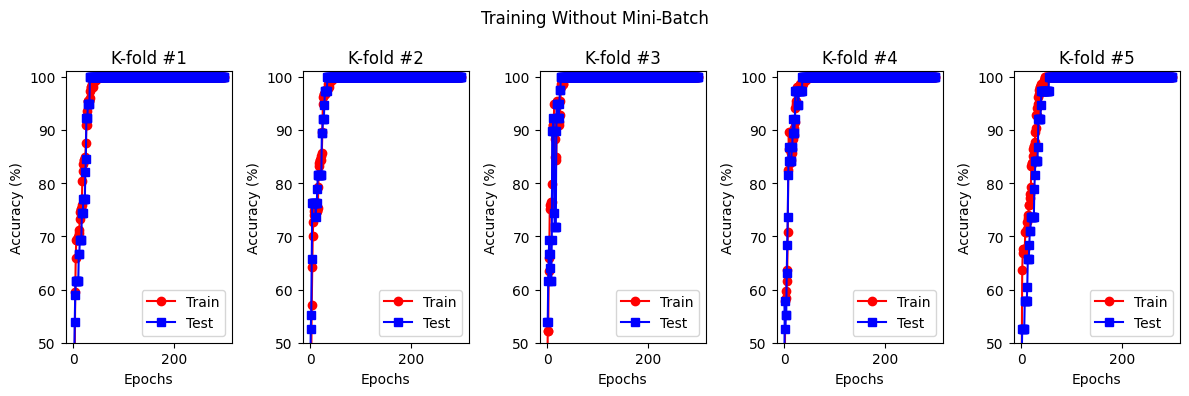

Applying 5 folds cross-validation #1
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 95.8333%
Applying 5 folds cross-validation #2
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%
Applying 5 folds cross-validation #3
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%
Applying 5 folds cross-validation #4
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%
Applying 5 folds cross-validation #5
 > Final accuracy of training ANN model: 100%
 > Final accuracy of testing ANN model: 100%


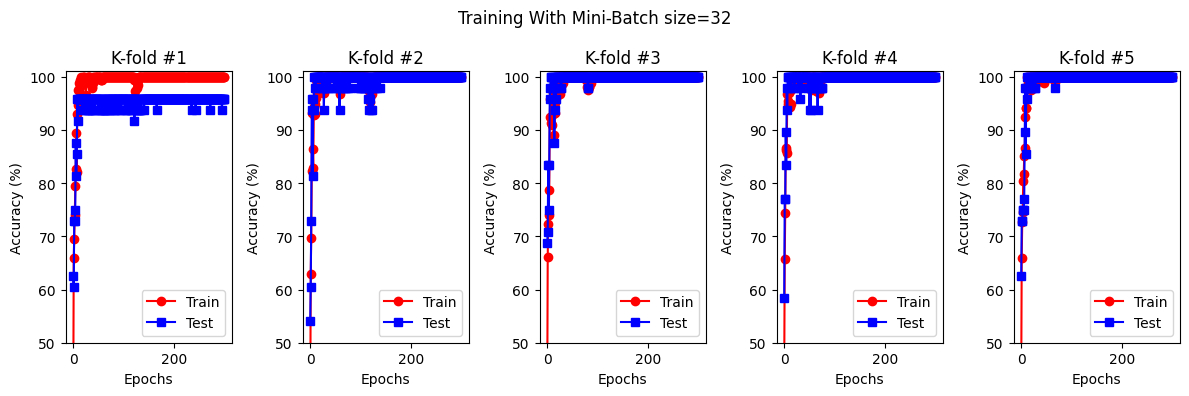

In [17]:
# Set the hyperparameters
numepochs = 300         # Number of training epochs
learning_rate = 0.01    # Number of learning rate
nLayers = 1             # Number of hidden layers
nUnits = 24             # Number of hidden units
batchsize = 32           # Number of batch to split
actFunHidden = 'tanh'   # activation function for hidden layer             
optimizer = 'Adam'      # optimizer function name
k_folds = 5             # Number of folds for cross-validation

# Train the model on cross validation without mini-batch
def finalTrainNoBatch(nUnits, nLayers, _input, _output, actFunHidden, validation_data, validation_labels, k_folds, i):
    # Create a model
    ann_final = ANN_Customizable(nUnits, nLayers, _input, _output, actFunHidden) 
    # Get data from i-fold
    train_data, train_labels, test_data, test_labels \
        = crossValidationPartition(validation_data, validation_labels, k_folds, i)
    # Trian the data for this fold
    train_accuracy, test_accuracy, losses \
        = trainModel(ann_final, train_data, train_labels, test_data, test_labels, numepochs, learning_rate, optimizer)
    # Report the final accuracy of the ANN model.
    final_train_accuracy = train_accuracy[-1]
    print(' > Final accuracy of training ANN model: %g%%' % final_train_accuracy)
    # test the data using the initially splitted test set for final evaluation
    final_test_accuracy = test_accuracy[-1]
    # final_test_accuracy = testModel(ann_final, final_test_data, final_test_labels)
    print(' > Final accuracy of testing ANN model: %g%%' % final_test_accuracy)

    # Save the trained model
    fileName = "StarType%d.pth" % (i+1) 
    tc.save(ann_final.state_dict(), fileName)
    
    ax[i].plot(train_accuracy,'ro-')
    ax[i].plot(test_accuracy,'bs-')
    ax[i].set_title('K-fold #' + str(i+1))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].legend(['Train','Test'], loc='lower right')
    ax[i].set_ylim([50,101])

    return ann_final

# Train the model on cross validation with mini-batch 32
def finalTrainInBatch(nUnits, nLayers, _input, _output, actFunHidden, validation_data, validation_labels, k_folds, batchsize, i):
    # Create a model
    ann_final = ANN_Customizable(nUnits, nLayers, _input, _output, actFunHidden) 
    # Trian the data for this fold
    train_data, train_labels, test_data, test_labels \
        = crossValidationPartition(validation_data, validation_labels, k_folds, i)
    # then convert them into PyTorch Datasets (data needs to be tensor format)
    train_dataset = TensorDataset(train_data, train_labels)
    test_dataset  = TensorDataset(final_test_data, final_test_labels)
    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])
    # Trian the data for this fold in mini-batch
    train_accuracy, test_accuracy, losses \
        = trainBatchModel(ann_final, train_loader, test_loader, numepochs, learning_rate, optimizer)
    # Report the final accuracy of the ANN model.
    final_train_accuracy = train_accuracy[-1]
    print(' > Final accuracy of training ANN model: %g%%' % final_train_accuracy)
    # test the data using the initially splitted test set for final evaluation
    final_test_accuracy = test_accuracy[-1]
    # final_test_accuracy = testModel(ann_final, final_test_data, final_test_labels)
    print(' > Final accuracy of testing ANN model: %g%%' % final_test_accuracy)

    # Save the trained model
    fileName = "StarType%d_MiniBatch%d.pth" % (i+1, batchsize) 
    tc.save(ann_final.state_dict(), fileName)

    # plot the results
    # fig.suptitle("K-Fold # " + str(i+1))
    # ax[0].plot(losses)
    # ax[0].set_ylabel('Loss')
    # ax[0].set_xlabel('Epochs')
    # ax[0].set_title('Losses with minibatch size=' + str(batchsize))

    ax[i].plot(train_accuracy,'ro-')
    ax[i].plot(test_accuracy,'bs-')
    ax[i].set_title('K-fold #' + str(i+1))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].legend(['Train','Test'], loc='lower right')
    ax[i].set_ylim([50,101])

    return ann_final


fig, ax = plt.subplots(1,5,figsize=(12,4))
fig.suptitle("Training Without Mini-Batch")
# Split the data to 5-fold for cross-validation
# Apply cross-validation
for i in range(k_folds):
    print("Applying %d folds cross-validation #%d" % (k_folds, (i+1)))
    finalTrainNoBatch(nUnits, nLayers, _input, _output, actFunHidden, validation_data, validation_labels, k_folds, i)
plt.tight_layout()
plt.show()
k_folds = 5

fig, ax = plt.subplots(1,5,figsize=(12,4))
fig.suptitle("Training With Mini-Batch size=" + str(batchsize))
# Apply cross-validation
for i in range(k_folds):
    print("Applying %d folds cross-validation #%d" % (k_folds, (i+1)))
    finalTrainInBatch(nUnits, nLayers, _input, _output, actFunHidden, validation_data, validation_labels, k_folds, batchsize, i)
plt.tight_layout()
plt.show()


### Test the Model

In [18]:
# Load the saved trained model
model = ANN_Customizable(nUnits, nLayers, _input, _output, actFunHidden)
model.load_state_dict(tc.load('Sepctrum3.pth'))

# print(model.state_dict())
# test the data
final_test_accuracy = testModel(model, final_test_data, final_test_labels)
print('Final accuracy of testing ANN model: %g%%' % final_test_accuracy)

FileNotFoundError: [Errno 2] No such file or directory: 'Sepctrum3.pth'